## George Shi

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas import Timestamp, date_range, Timedelta

In [311]:
s1 = pd.read_csv('site_1.csv')
s2 = pd.read_csv('site_2.csv')
s3 = pd.read_csv('site_3.csv')
s5 = pd.read_csv('site_5.csv')
s6 = pd.read_csv('site_6.csv')

### Reconfiguring the data

In [312]:
s1.columns = ['time', 'kWH']
s1['time'] = pd.to_datetime(s1['time'])
s1['hour'] = s1.time.dt.hour
s1['date'] = s1.time.dt.date
s1['day'] = s1.time.dt.dayofweek
s1['kW'] = s1['kWH']*4 #Since the time intervals are in 15 mins, which is 1/4 of an hour so times 4 to get to kW
s1.head()

,time,kWH,hour,date,day,kW
0,2017-05-01 00:00:00,1533.6,0,2017-05-01,0,6134.4
1,2017-05-01 00:15:00,1490.4,0,2017-05-01,0,5961.6
2,2017-05-01 00:30:00,1425.6,0,2017-05-01,0,5702.4
3,2017-05-01 00:45:00,1414.8,0,2017-05-01,0,5659.2
4,2017-05-01 01:00:00,1371.6,1,2017-05-01,0,5486.4


In [313]:
s2.columns = ['time', 'kWH']
s2['time'] = pd.to_datetime(s2['time'])
s2['hour'] = s2.time.dt.hour
s2['date'] = s2.time.dt.date
s2['day'] = s2.time.dt.dayofweek
s2['kW'] = s2['kWH']*4 #Since the time intervals are in 15 mins, which is 1/4 of an hour so times 4 to get to kW

s3.columns = ['time', 'kWH']
s3['time'] = pd.to_datetime(s3['time'])
s3['hour'] = s3.time.dt.hour
s3['date'] = s3.time.dt.date
s3['day'] = s3.time.dt.dayofweek
s3['kW'] = s3['kWH']*4 #Since the time intervals are in 15 mins, which is 1/4 of an hour so times 4 to get to kW

s5.columns = ['time', 'kWH']
s5['time'] = pd.to_datetime(s5['time'])
s5['hour'] = s5.time.dt.hour
s5['date'] = s5.time.dt.date
s5['day'] = s5.time.dt.dayofweek
s5['kW'] = s5['kWH']*4 #Since the time intervals are in 15 mins, which is 1/4 of an hour so times 4 to get to kW

s6.columns = ['time', 'kWH']
s6['time'] = pd.to_datetime(s6['time'])
s6['hour'] = s6.time.dt.hour
s6['date'] = s6.time.dt.date
s6['day'] = s6.time.dt.dayofweek
s6['kW'] = s6['kWH']*4 #Since the time intervals are in 15 mins, which is 1/4 of an hour so times 4 to get to kW


### Checking out Date vs kWH

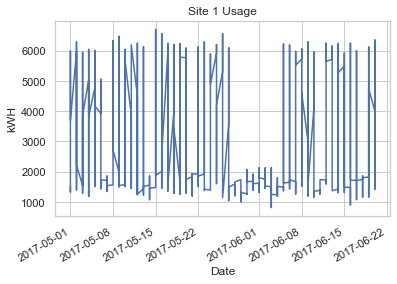

In [244]:
plt.plot('date', 'kWH', data=s1)
plt.title('Site 1 Usage')
plt.xlabel('Date')
plt.ylabel('kWH')
plt.gcf().autofmt_xdate()

Text(0, 0.5, 'kWH')

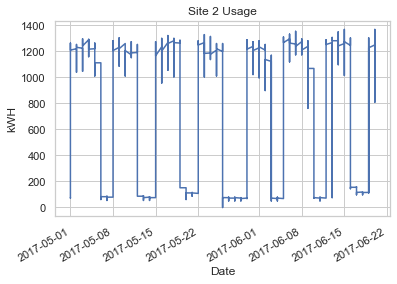

In [243]:
plt.plot('date', 'kWH', data=s2)
plt.title('Site 2 Usage')
plt.xlabel('Date')
plt.gcf().autofmt_xdate()
plt.ylabel('kWH')

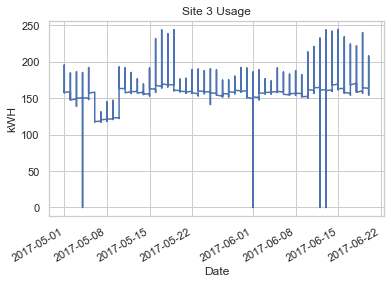

In [245]:
plt.plot('date', 'kWH', data=s3)
plt.title('Site 3 Usage')
plt.xlabel('Date')
plt.ylabel('kWH')
plt.gcf().autofmt_xdate()

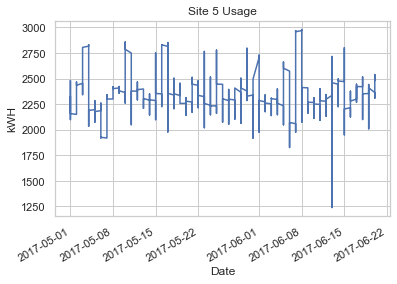

In [246]:
plt.plot('date', 'kWH', data=s5)
plt.title('Site 5 Usage')
plt.xlabel('Date')
plt.ylabel('kWH')
plt.gcf().autofmt_xdate()

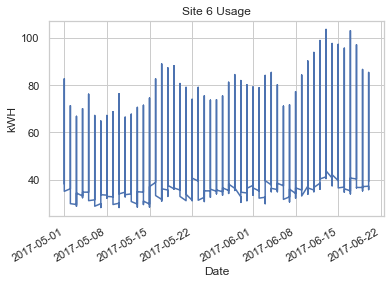

In [247]:
plt.plot('date', 'kWH', data=s6)
plt.title('Site 6 Usage')
plt.xlabel('Date')
plt.ylabel('kWH')
plt.gcf().autofmt_xdate()

### Weather Adjustment Function

In [314]:
def weather(start, end, data, dates):   
    
    start = Timestamp(start)
    end = Timestamp(end)
    #Adjusted period is a two-hour period beginning with the start of the hour that is 4 hours prior to event
    hours = list(range(start.hour -4, start.hour - 2))
    abau = data[(data.date == start.date()) & (data.hour.isin(hours))] #Adjustment Basis Average Usage
    abau = abau.groupby('hour').mean() 
    abau = abau.mean() #Average out results of the hour
    abac = data[(data.date.isin(dates)) & (data.hour.isin(hours))] #Adjustment Basis Average CBL
    abac = abac.groupby('hour').mean()
    abac = abac.mean() #Average out results of the hour
    adjusted_val = abau/abac
    return adjusted_val

### CBL Calculation

In [339]:
def cbl(data, start, end):
    
    #Establishing window of 30 days
    start = Timestamp(start) #Set our demand reponse dispatch start time
    end = Timestamp(end) #Set our demand response dispatch end time
    dis_hrs = date_range(start, end, freq = 'H').hour.tolist() #Set dispatch hours
    window = start.date() - Timedelta(30, unit = 'days') #30 day time window
    nd = date_range(window, periods = 30).date.tolist() #New dates within the window
    dates = data[data.date.isin(nd)] #Reconfigure data dates
    
    isv = dates[dates.hour.isin(dis_hrs)] #Initial Seed Value
    isv = isv[isv['date'] != start.date()]
    isv = isv.groupby(['date','hour']).mean().reset_index() #Group by hour
    lb = isv['kW'].max()*0.25 #Lower bound is equal to 0.25 * Maximum Load
    low_usage = isv.groupby(['date']).mean() #Groupby a specific date
    low_usage_dates = low_usage[low_usage.kW < lb].index.tolist()
    days = list(range(1,6)) #Limit to weekdays, ignore weekends due to time constraints 
    weekday = [i for i in isv.date.to_list() if not i.isoweekday() in days]
    weekday = list(set(weekday)) #Only keep the weekdays
    
    ##IGNORING WEEKENDS AND HOLIDAYS TO SAVE TIME
    
    #Establishing CBL Window
    max_days = isv.date.unique().tolist()
    new_days = [i for i in max_days]
    new_days.sort(reverse = True)
    if len(new_days) > 10: #Using CBL Window of up to 10 days, need to set limit for windows that exceed 10
        cbl_wind = new_days[:10] #Upper limit
    else:
        cbl_wind = new_days
        
    avg = isv.groupby('date').mean() #Create ISV average and group by dates
    avg = avg[avg.index.isin(cbl_wind)]
    avg['rank'] = avg['kW'].rank(ascending = False) #Ranks days from CBL Window according to average daily event period usage level 
    bd = avg[avg['rank'] <= 5].index.tolist() #Keep up to max of 5 weekdays
    baseline = dates[dates.date.isin(bd)]
    baseline = baseline.groupby('hour').mean()
    
    event = data.groupby(['hour']).mean().reset_index() #Organize by hour
    event['baseline'] = baseline.kW #Baseline is simple average of the corresponding hourly Loads from the CBL Basis for Weekdays
    adjusted = weather(start = start, end = end, data = data, dates = cbl_wind) #Call weather function
    event['weather_adjusted'] = event.baseline * adjusted.kW #Accounts for the weather
    pb = event[event.hour.isin(dis_hrs)]
    pb['performance'] = pb['weather_adjusted'] - pb['kW'] #Check to see how the system performed during the event by subtracting load from adjusted baseline
    event['performance'] = pb.performance
    
    return event



In [340]:
start = '06-13-17 2:00 PM'
end = '06-13-17 6:00PM'
s1cbl = cbl(s1, start, end)
s1cbl['load'] = s1cbl['kW']
p1 = s1cbl.iloc[14:18,6] #Performance for Site 1
print(s1cbl)
print(p1)

    hour     kWH  day       kW  baseline  weather_adjusted   performance  \
0      0  4719.6    1  18878.4  12607.92      16380.522419           NaN   
1      1  4311.9    1  17247.6  14891.04      19346.808558           NaN   
2      2  2702.7    1  10810.8  15135.12      19663.923349           NaN   
3      3  4222.8    1  16891.2  10588.32      13756.608000           NaN   
4      4  4600.8    1  18403.2  17007.84      22097.007628           NaN   
5      5  4322.7    1  17290.8  13865.04      18013.803907           NaN   
6      6  2008.8    1   8035.2  12957.84      16835.147163           NaN   
7      7  4619.7    1  18478.8  12322.80      16010.087442           NaN   
8      8  5135.4    1  20541.6  11856.24      15403.921116           NaN   
9      9  3510.0    1  14040.0  13834.80      17974.515349           NaN   
10    10  3445.2    1  13780.8  14983.92      19467.480558           NaN   
11    11  3342.6    1  13370.4  13677.12      17769.653581           NaN   
12    12  24

/Users/georgeshi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


### CBL for each site with adjusted and load kWs

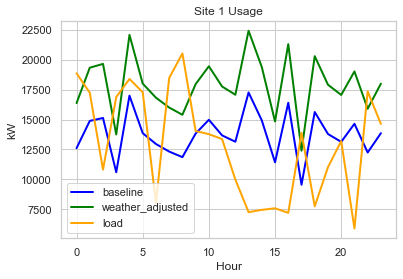

In [347]:
plt.plot('hour', 'baseline', data=s1cbl, color='blue', linewidth=2)
plt.plot('hour', 'weather_adjusted', data=s1cbl, color='green', linewidth=2)
plt.plot('hour', 'load', data = s1cbl, color='orange', linewidth=2)
plt.title('Site 1 Usage')
plt.xlabel('Hour')
plt.ylabel('kW')
plt.legend()

In [342]:
s2cbl = cbl(s2, start, end)
s2cbl['load'] = s2cbl['kW'] 
p2 = s2cbl.iloc[14:18,6]

s3cbl = cbl(s3, start, end)
s3cbl['load'] = s3cbl['kW'] 
p3 = s3cbl.iloc[14:18,6]

s5cbl = cbl(s5, start, end)
s5cbl['load'] = s5cbl['kW'] 
p5 = s5cbl.iloc[14:18,6]

s6cbl = cbl(s6, start, end)
s6cbl['load'] = s6cbl['kW'] 
p6 = s6cbl.iloc[14:18,6]

/Users/georgeshi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/georgeshi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/Users/georgeshi/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:45: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in t

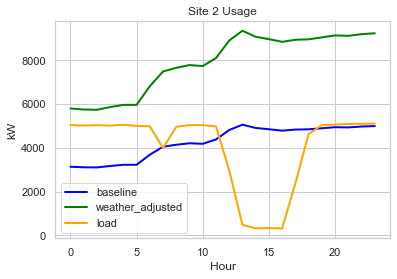

In [348]:
plt.plot('hour', 'baseline', data=s2cbl, color='blue', linewidth=2)
plt.plot('hour', 'weather_adjusted', data=s2cbl, color='green', linewidth=2)
plt.plot('hour', 'load', data = s2cbl, color='orange', linewidth=2)
plt.title('Site 2 Usage')
plt.xlabel('Hour')
plt.ylabel('kW')
plt.legend()

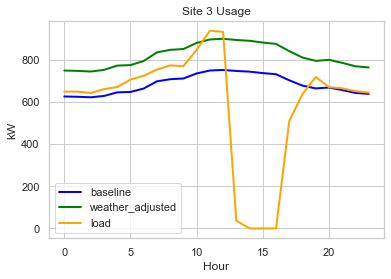

In [349]:
plt.plot('hour', 'baseline', data=s3cbl, color='blue', linewidth=2)
plt.plot('hour', 'weather_adjusted', data=s3cbl, color='green', linewidth=2)
plt.plot('hour', 'load', data = s3cbl, color='orange', linewidth=2)
plt.title('Site 3 Usage')
plt.xlabel('Hour')
plt.ylabel('kW')
plt.legend()

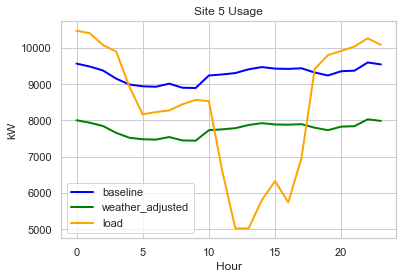

In [350]:
plt.plot('hour', 'baseline', data=s5cbl, color='blue', linewidth=2)
plt.plot('hour', 'weather_adjusted', data=s5cbl, color='green', linewidth=2)
plt.plot('hour', 'load', data = s5cbl, color='orange', linewidth=2)
plt.title('Site 5 Usage')
plt.xlabel('Hour')
plt.ylabel('kW')
plt.legend()

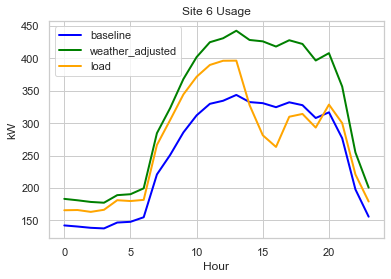

In [351]:
plt.plot('hour', 'baseline', data=s6cbl, color='blue', linewidth=2)
plt.plot('hour', 'weather_adjusted', data=s6cbl, color='green', linewidth=2)
plt.plot('hour', 'load', data = s6cbl, color='orange', linewidth=2)
plt.title('Site 6 Usage')
plt.xlabel('Hour')
plt.ylabel('kW')
plt.legend()

### Performance During the Dispatch

In [336]:
print(p1,p2,p3,p5,p6)

14    11958.928744
15     7269.049674
16    14129.661767
17    -1501.253581
Name: performance, dtype: float64 14    8745.482728
15    8621.967451
16    8515.276107
17    6545.623295
Name: performance, dtype: float64 14    889.804357
15    881.532718
16    874.984337
17    331.651499
Name: performance, dtype: float64 14    2123.998527
15    1562.077819
16    2141.213693
17     929.308135
Name: performance, dtype: float64 14    100.496870
15    144.983398
16    154.959688
17    118.079452
Name: performance, dtype: float64
